In [1]:
# контроль и анализ
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
# для работы с изображениями
from PIL import ImageOps, Image
# для загрузки и предобработки изображений
from sklearn.model_selection import train_test_split
# для работы с datasets и моделями
from functools import partial
from transformers import  AutoTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
# Для оценки качества модели
from torchmetrics.regression import MeanAbsoluteError

In [2]:
import sys
sys.path.append('scripts')  # путь к папке, где лежaт utils

In [3]:
%load_ext autoreload
%autoreload 2

**Цель проекта:** Получить DL-модель, способную оценить калорийность блюда.

**Описание задачи:**  Создать и обучить нейросеть, которая будет предсказывать калорийность блюд. Полученную модель можно интегрировать во многие fitness и health-приложения, она будет полезна тем, кто следит за своим здоровьем.

**Целевая метрика:** Модель будет считаться готовой к интеграции в продукт при точности оценки MAE < 50 (MAE — Mean Absolute Error) на тестовой выборке.

**Описание данных:** Cодержит фотографии блюд, описание ингредиентов, а также общую массу порции и калорийность

📄 data/ingredients.csv:
 - **id**— ID ингредиента.
 - **ingr** — название ингредиента.
    
📄 data/dish.csv:
- **dish_id** — ID блюда.
- **total_calories** — общее число калорий. Это целевая переменная.
- **total_mass** — масса блюда.
- **ingredients** — список всех ID ингредиентов в формате *ingr_0000000122*; *ingr_0000000026* ;.., где ненулевая часть соответствует ID ингредиента из ***data/ingredients.csv***.
- **split** — метка, указывающая, куда отнести блюдо: *train/test*. Эта метка поможет разделить датасет при тренировке.

🖼️ data/images:  датасет с фотографиями блюд, каждая директория соответствует *dish_id* из *data/dish.csv* и содержит **rgb.png** фото блюда.

**Общий план работы с предоставленными данными можно представить следующим образом:**

 - **Этап 1**. Проведите исследовательский анализ (*EDA*):
      - Загрузить датасет и визуализируйте часть данных. Изучить то, с чем предстоит работать
      - Сформирать видение: как вы будете решать задачу, какие подходы к обогащению/аугментации данных примените и почему, на какие метрики будете ориентироваться при обучении.
 - **Этап 2**. Реализуйте пайплайн обучения:
      - Используя **.py** -файлы для сохранения кода, реализуйте: Загрузчики данных и датасеты. Опциональный код предобработки/аугментации данных. Код обучения и валидации для импортирования в виде одной функции (train). Конфиг-файл для запуска модели и сохранения результатов обучения. Код для получения воспроизводимых результатов (seed) с выводом метрик.
 - **Этап 3**. Обучение модели:
    - Выполните обучение модели на предоставленной ВМ с использованием кода с этапа 2.
    - Запуск обучения проводите в Jupyter Notebook с логированием результатов в stdout ячейки. Чтобы ускорить обучение, используйте GPU, предоставленную в ВМ.
    - По достижении заданного качества сохраните артефакт обученной модели. Модель должна сохраняться/импортироваться согласно пути, указанному в конфигурационном файле.
 - **Этап 4**. Валидация качества:
    - В Jupyter Notebook допишите код импорта и инференса предобученной модели (либо же импортируйте готовый код из .py-файла). Запустите модель на тестовом сплите данных test и выведите финальную целевую метрику по модели
    - Выведите топ-5 блюд, по которым оценка модели наименее точна. Опишите возможные причины низкого качества на этих примерах




## Этап 1. Загрузка и предобработка данных

Чтение исходных данных в таблиц:

In [4]:
dish  = pd.read_csv('data/dish.csv')
ingredients = pd.read_csv('data/ingredients.csv')

#### Текстовые(табличные) данные

Таблица **dish**

In [5]:
dish.head()

dish_id  total_calories  total_mass  \
0  dish_1561662216      300.794281       193.0   
1  dish_1561662054      419.438782       292.0   
2  dish_1562008979      382.936646       290.0   
3  dish_1560455030       20.590000       103.0   
4  dish_1558372433       74.360001       143.0   

                                         ingredients  split  
0  ingr_0000000508;ingr_0000000122;ingr_000000002...   test  
1  ingr_0000000312;ingr_0000000026;ingr_000000002...  train  
2  ingr_0000000448;ingr_0000000520;ingr_000000046...   test  
3    ingr_0000000471;ingr_0000000031;ingr_0000000347  train  
4                                    ingr_0000000453  train

In [6]:
ingredients.head()

id            ingr
0   1  cottage cheese
1   2    strawberries
2   3    garden salad
3   4           bacon
4   5        potatoes

Очевидно, что нужно будет работать с ингредиентами, чтобы обучать модель - вопрос только в том, с какими данными - из таблицы **dish** или таблицы **ingredients**.
- данные из **dish**, то получится более формальный подход, когда все ингредиенты будут четко пронумерованы изначально;
- данные из **ingredients** если их шифровать можно будет учитывать взаимосвязи типа potatoes - potato skins. Это может быть полезно, однако возможны ложные аналогии.
- данные из **ingredients** если их шифровать можно будет использовать для новых данных и ингредиентов, которых нет в изначальной таблице **ingredients** - будет конечно хуже, но все так что-то может подцепить

Так как выбрали использовать описание ингредиентов, то тогда создадим соответствующий столбец **ingredients2text** в основной таблице:

In [7]:
dish['ingredients_list'] = dish['ingredients'].apply(lambda x: [int(id[-3:]) for id in str(x).split(';')])

In [8]:
dish.head()

dish_id  total_calories  total_mass  \
0  dish_1561662216      300.794281       193.0   
1  dish_1561662054      419.438782       292.0   
2  dish_1562008979      382.936646       290.0   
3  dish_1560455030       20.590000       103.0   
4  dish_1558372433       74.360001       143.0   

                                         ingredients  split  \
0  ingr_0000000508;ingr_0000000122;ingr_000000002...   test   
1  ingr_0000000312;ingr_0000000026;ingr_000000002...  train   
2  ingr_0000000448;ingr_0000000520;ingr_000000046...   test   
3    ingr_0000000471;ingr_0000000031;ingr_0000000347  train   
4                                    ingr_0000000453  train   

                                    ingredients_list  
0  [508, 122, 26, 524, 94, 23, 189, 54, 29, 328, ...  
1  [312, 26, 29, 122, 508, 513, 520, 525, 161, 94...  
2  [448, 520, 462, 514, 152, 312, 291, 45, 122, 6...  
3                                     [471, 31, 347]  
4                                              [453]

In [9]:
def ingredients2name (ids):
    str = []
    for id in ids:
        name = ingredients['ingr'].loc[ingredients['id']==id].tolist() 
        str += name
    return ', '.join(names for names in str)

In [10]:
dish['ingredients2text'] = dish['ingredients_list'].apply(ingredients2name)
dish.head()

dish_id  total_calories  total_mass  \
0  dish_1561662216      300.794281       193.0   
1  dish_1561662054      419.438782       292.0   
2  dish_1562008979      382.936646       290.0   
3  dish_1560455030       20.590000       103.0   
4  dish_1558372433       74.360001       143.0   

                                         ingredients  split  \
0  ingr_0000000508;ingr_0000000122;ingr_000000002...   test   
1  ingr_0000000312;ingr_0000000026;ingr_000000002...  train   
2  ingr_0000000448;ingr_0000000520;ingr_000000046...   test   
3    ingr_0000000471;ingr_0000000031;ingr_0000000347  train   
4                                    ingr_0000000453  train   

                                    ingredients_list  \
0  [508, 122, 26, 524, 94, 23, 189, 54, 29, 328, ...   
1  [312, 26, 29, 122, 508, 513, 520, 525, 161, 94...   
2  [448, 520, 462, 514, 152, 312, 291, 45, 122, 6...   
3                                     [471, 31, 347]   
4                                              [453]   

                                    ingredients2text  
0  soy sauce, garlic, white rice, parsley, onions...  
1  pepper, white rice, mixed greens, garlic, soy ...  
2  jalapenos, lemon juice, pork, wheat berry, cab...  
3           cherry tomatoes, cucumbers, baby carrots  
4                                         deprecated

In [11]:
dish.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3262 entries, 0 to 3261
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   dish_id           3262 non-null   object 
 1   total_calories    3262 non-null   float64
 2   total_mass        3262 non-null   float64
 3   ingredients       3262 non-null   object 
 4   split             3262 non-null   object 
 5   ingredients_list  3262 non-null   object 
 6   ingredients2text  3262 non-null   object 
dtypes: float64(2), object(5)
memory usage: 178.5+ KB


 - Пропуск данных в таблицах нет;
 - Всего объектов 3262.

In [12]:
len(dish['dish_id'].unique())

3262

Все блюда **оригинальные**

In [13]:
dish['split'].value_counts(normalize=True)

split
train    0.844574
test     0.155426
Name: proportion, dtype: float64

Разбивка на тестовые и тренировочные данные примерно 84 на 16 процентов

Посмотрим описание численных данных:

In [14]:
dish.describe()

total_calories   total_mass
count     3262.000000  3262.000000
mean       255.012738   214.980074
std        219.637570   161.497428
min          0.000000     1.000000
25%         80.114996    92.000000
50%        209.110062   177.000000
75%        375.122963   305.000000
max       3943.325195  3051.000000

Есть странные блюда с нулевой калорийностью и массой 3 кг. Можно посмотреть гистограмму распределения и вывести 5% выпадающий значений 

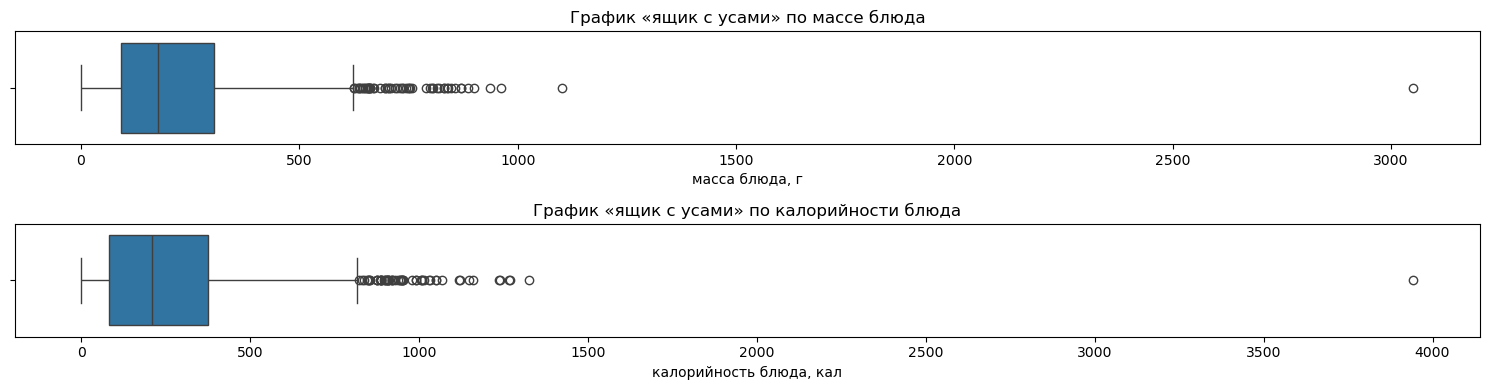

In [15]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 4))
sns.boxplot(x='total_mass', data=dish, ax=ax1).set(xlabel = "масса блюда, г",
                                            title = "График «ящик с усами» по массе блюда")
sns.boxplot(x='total_calories', data=dish, ax=ax2).set(xlabel = "калорийность блюда, кал",
                                            title = "График «ящик с усами» по калорийности блюда")
plt.tight_layout()
plt.show()

Можно прикинуть, что:
 - калорийность картошки фри 350 кал /100 грамм - теоретически что то на 300 грамм с калорийностью до 1500 можно;
 - если использовать google поиск можно найти, что "средний размер блюда, которое может съесть человек за один раз, составляет примерно 350-400 г (или примерно 2/3 от объёма желудка)" - то есть 3 кг еды на тарелке, наверное многовато- особенно в train

In [16]:
heavy_dish = dish.loc[dish['total_mass'] > 850]
heavy_dish

dish_id  total_calories  total_mass  \
28    dish_1566920365      490.421692       871.0   
328   dish_1561739805      696.363525      1102.0   
1518  dish_1560974769     3943.325195      3051.0   
1951  dish_1563476577     1238.033691       857.0   
2321  dish_1564590352      497.915833       962.0   
2658  dish_1563984296      436.337067       871.0   
2838  dish_1563305083     1234.856323       901.0   
3007  dish_1561739760      452.163513       937.0   
3106  dish_1564675240      502.878784       886.0   

                                            ingredients  split  \
28    ingr_0000000475;ingr_0000000437;ingr_000000016...   test   
328   ingr_0000000040;ingr_0000000027;ingr_000000001...  train   
1518  ingr_0000000036;ingr_0000000251;ingr_000000004...  train   
1951  ingr_0000000025;ingr_0000000027;ingr_000000013...  train   
2321  ingr_0000000038;ingr_0000000037;ingr_000000047...  train   
2658  ingr_0000000128;ingr_0000000161;ingr_000000047...   test   
2838  ingr_0000000203;ingr_0000000030;ingr_000000013...  train   
3007  ingr_0000000338;ingr_0000000294;ingr_000000004...  train   
3106  ingr_0000000121;ingr_0000000161;ingr_000000044...  train   

                                       ingredients_list  \
28                                 [475, 437, 161, 128]   
328          [40, 27, 13, 437, 8, 37, 338, 29, 41, 294]   
1518  [36, 251, 47, 52, 26, 471, 367, 32, 203, 122, ...   
1951  [25, 27, 133, 518, 94, 540, 36, 23, 367, 291, ...   
2321              [38, 37, 475, 121, 161, 437, 13, 128]   
2658                       [128, 161, 475, 37, 437, 38]   
2838  [203, 30, 133, 27, 161, 524, 28, 35, 25, 29, 2...   
3007            [338, 294, 41, 13, 29, 27, 40, 37, 437]   
3106                     [121, 161, 440, 128, 437, 475]   

                                       ingredients2text  
28           salsa, sweet potato, olive oil, egg whites  
328   raspberries, broccoli, berries, sweet potato, ...  
1518  spinach (raw), tortilla chips, corn, cheese, w...  
1951  beef, broccoli, shallots, thyme, onions, ginge...  
2321  pineapple, cantaloupe, salsa, watermelon, oliv...  
2658  egg whites, olive oil, salsa, cantaloupe, swee...  
2838  chili, lettuce, shallots, broccoli, olive oil,...  
3007  vinaigrette, granola, blackberries, berries, m...  
3106  watermelon, olive oil, grapes, egg whites, swe...

In [17]:
heavy_dish_id = heavy_dish['dish_id'].tolist()
heavy_dish_mass = heavy_dish['total_mass'].tolist()

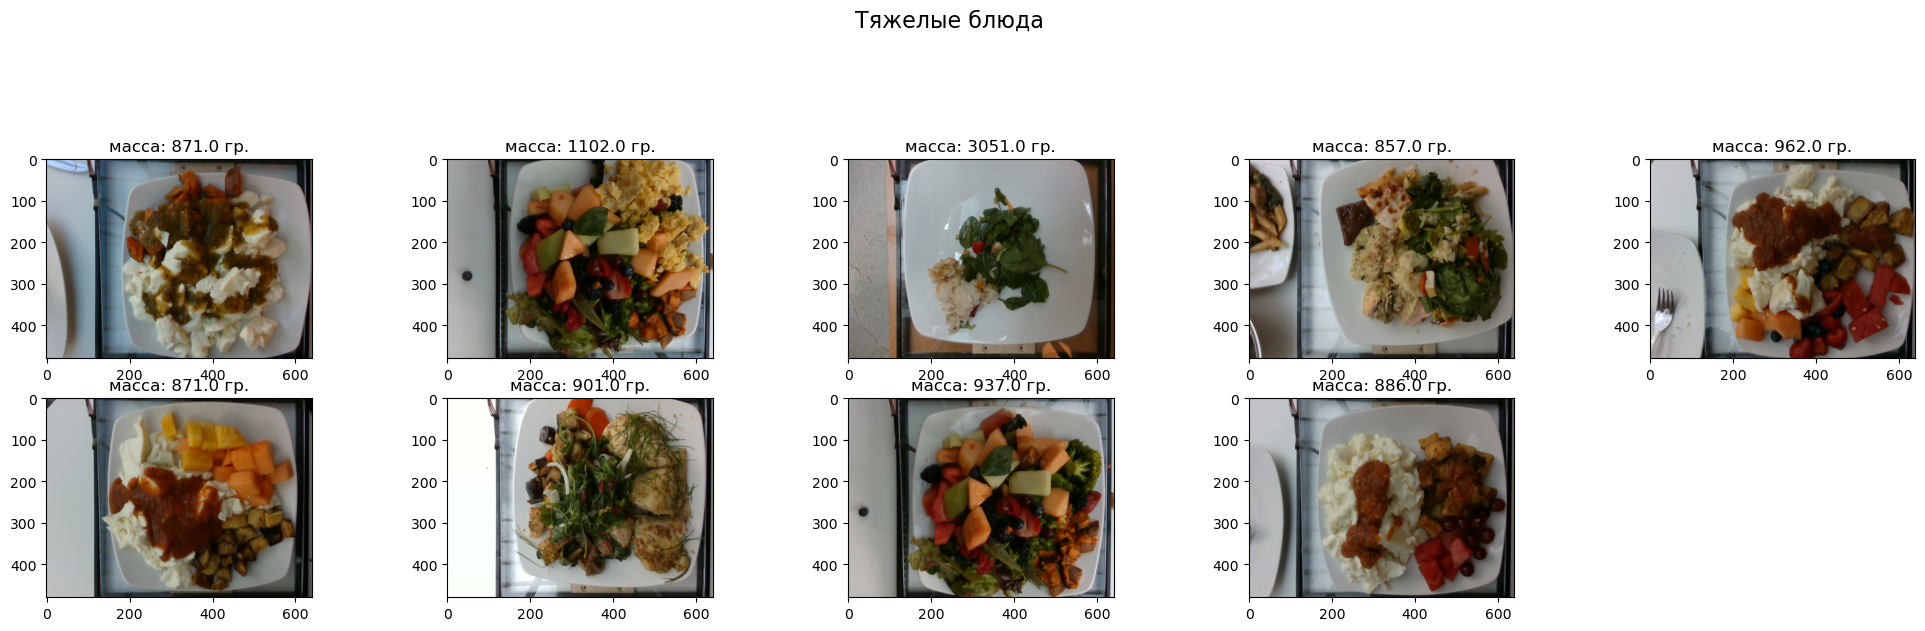

In [18]:
image_path = 'data/images/'
fig = plt.figure(figsize=(25,15))
fig.suptitle('Тяжелые блюда', fontsize=16)
#plt.tight_layout()
for indx, food in enumerate(zip(heavy_dish_id,heavy_dish_mass)):
    image = Image.open(image_path + food[0] + '/rgb.png')
    fig.add_subplot(5, 5, indx+1)
    plt.title(f"масса: {food[1]} гр.")
    plt.imshow(image)
plt.show()

Блюдо с массой 3кг - точно ошибка, все остальное, могут быть варианты.

In [19]:
light_dish = dish.loc[dish['total_mass'] < 10]
light_dish_id = light_dish['dish_id'].tolist()
light_dish_mass = light_dish['total_mass'].tolist()

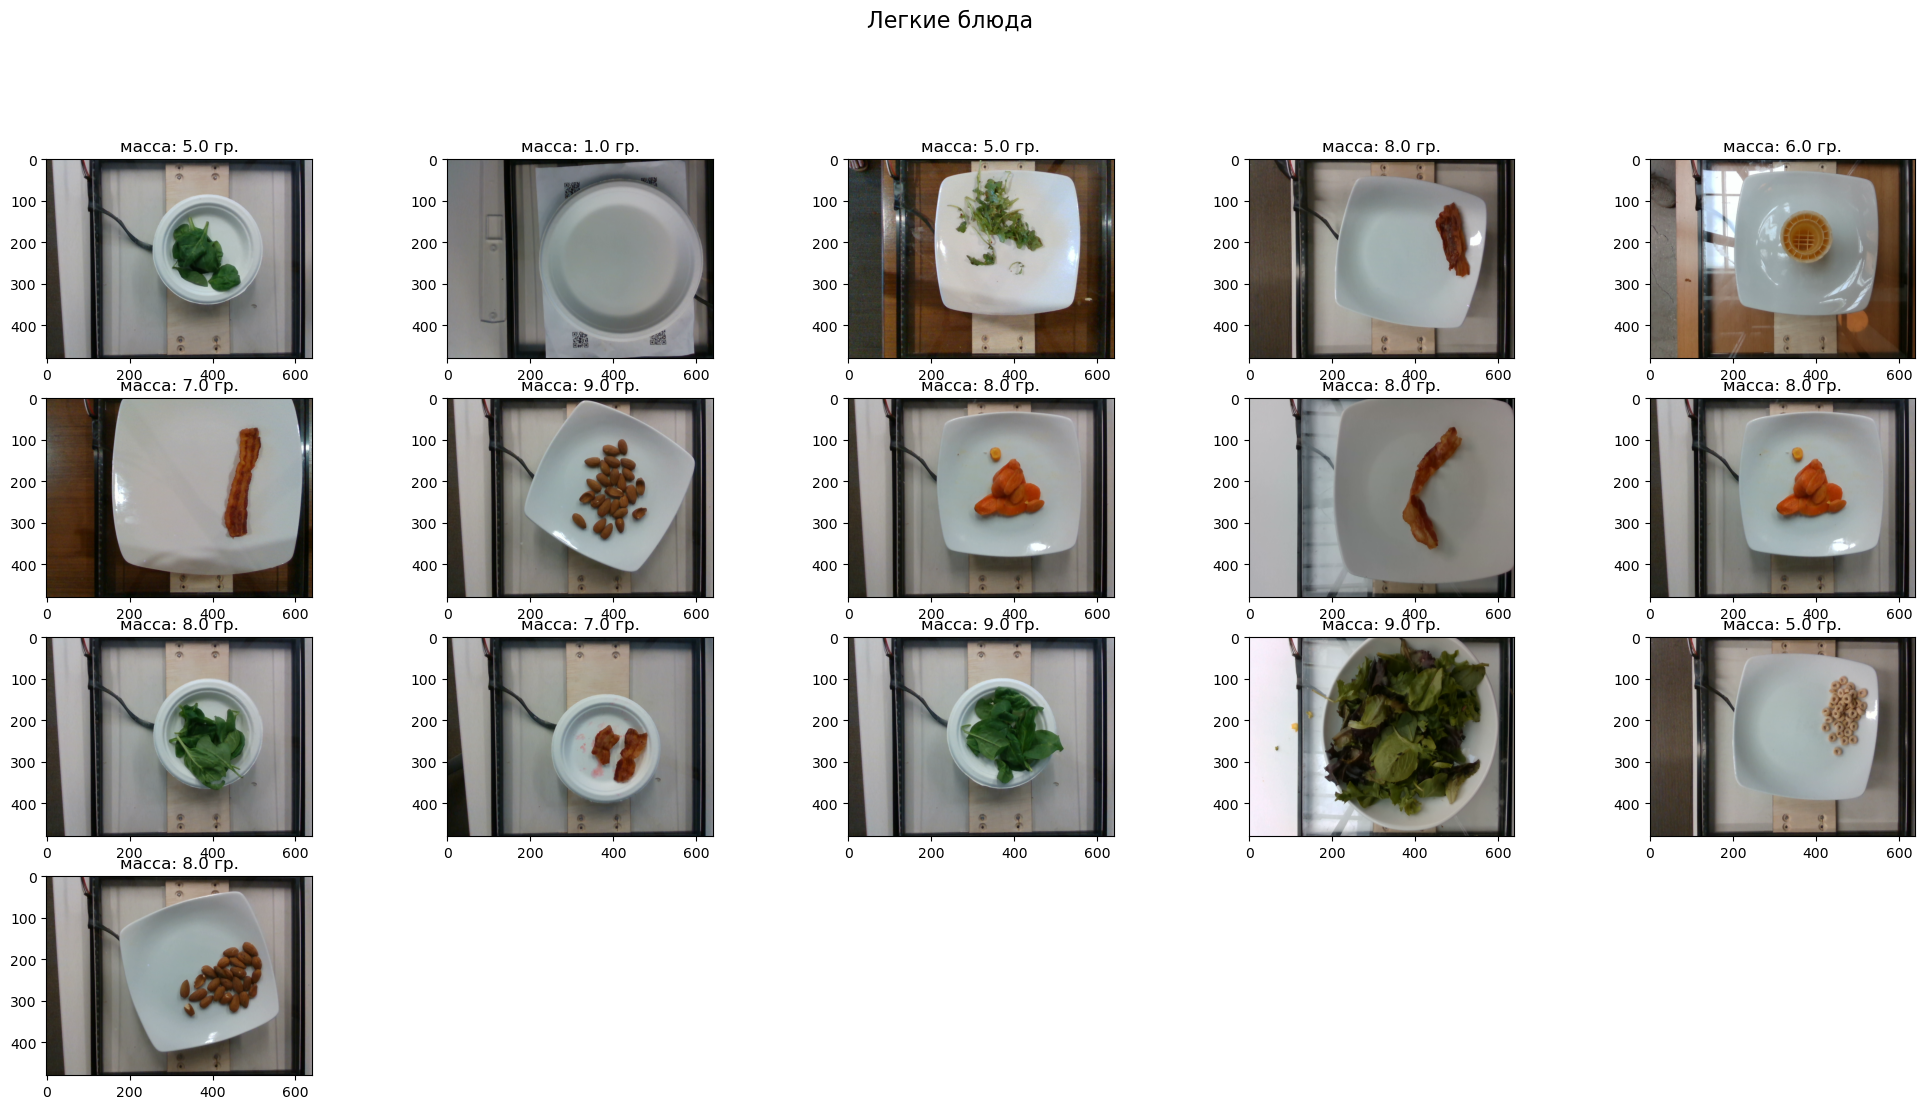

In [20]:
image_path = 'data/images/'
fig = plt.figure(figsize=(25,15))
fig.suptitle('Легкие блюда', fontsize=16)
#plt.tight_layout()
for indx, food in enumerate(zip(light_dish_id,light_dish_mass)):
    image = Image.open(image_path + food[0] + '/rgb.png')
    fig.add_subplot(5, 5, indx+1)
    plt.title(f"масса: {food[1]} гр.")
    plt.imshow(image)
plt.show()

С легкими блюдами проблем нет

In [21]:
kall_dish = dish.loc[dish['total_calories'] > 1000]
kall_dish_id = kall_dish['dish_id'].tolist()
kall_dish_mass = kall_dish['total_calories'].tolist()

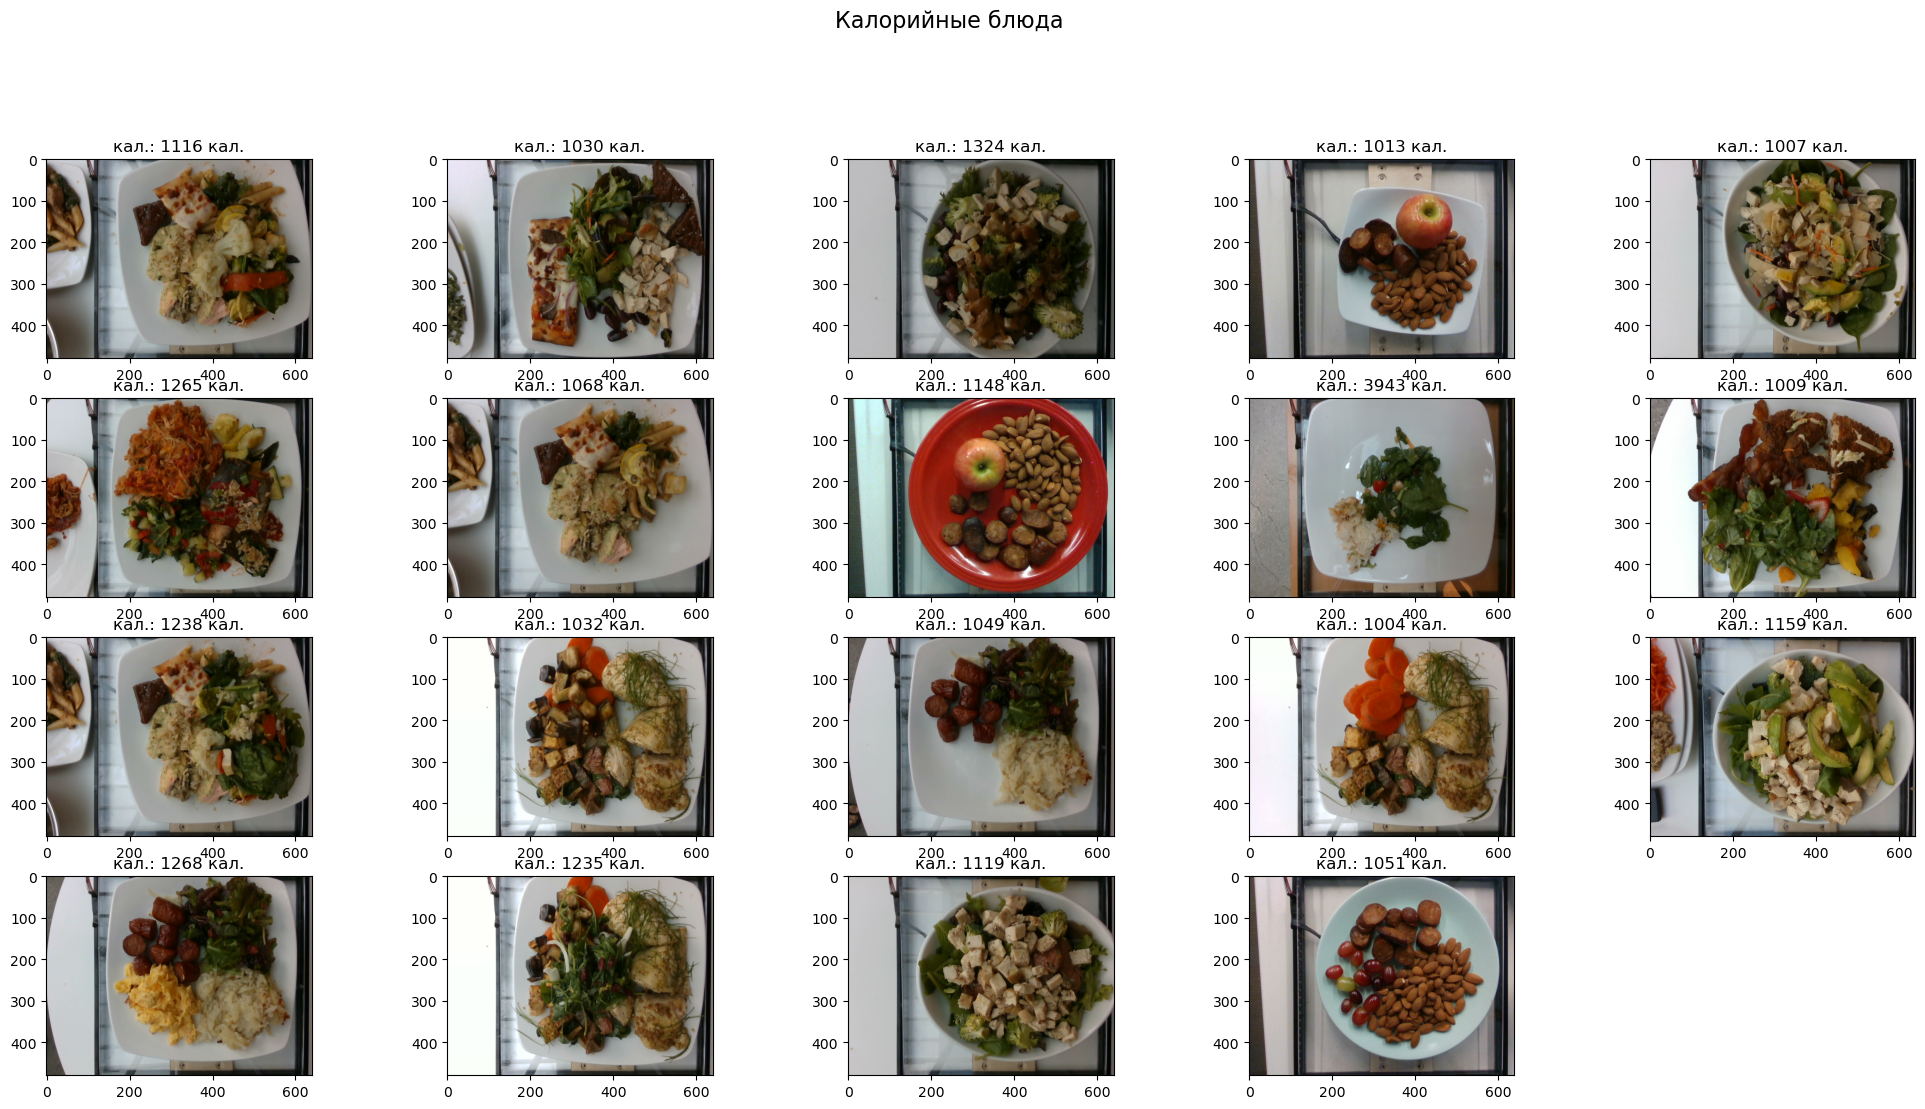

In [22]:
image_path = 'data/images/'
fig = plt.figure(figsize=(25,15))
fig.suptitle('Калорийные блюда', fontsize=16)
#plt.tight_layout()
for indx, food in enumerate(zip(kall_dish_id, kall_dish_mass)):
    image = Image.open(image_path + food[0] + '/rgb.png')
    fig.add_subplot(5, 5, indx+1)
    plt.title(f"кал.: {round(food[1])} кал.")
    plt.imshow(image)
plt.show()

Проблема все с тем же блюдом, все остальное возможно.

Таким образом, итоговый датасет может выглядить как:

In [23]:
dataset = dish[['total_calories', 'total_mass', 'ingredients2text', 'dish_id','split']].copy()      # скопировали только нужные столбцы
dataset.drop(index=1518, inplace=True)                                   # убрали строку 
dataset = dataset.reset_index(drop=True)   
dataset.head()

total_calories  total_mass  \
0      300.794281       193.0   
1      419.438782       292.0   
2      382.936646       290.0   
3       20.590000       103.0   
4       74.360001       143.0   

                                    ingredients2text          dish_id  split  
0  soy sauce, garlic, white rice, parsley, onions...  dish_1561662216   test  
1  pepper, white rice, mixed greens, garlic, soy ...  dish_1561662054  train  
2  jalapenos, lemon juice, pork, wheat berry, cab...  dish_1562008979   test  
3           cherry tomatoes, cucumbers, baby carrots  dish_1560455030  train  
4                                         deprecated  dish_1558372433  train

Сохраним разбивку на датасеты (тренировочный, валидационный и тестовый) в папку data. Тестовый сделаем по столбцу "split" - "test", а тренировочные и валидационные данные разобьем дополнительно. Мне кажется раз в задании есть пункт "валидация данных", то там для интерференса используем "test", и просто взять их же ранее для валидации - наверное не совсем верно.

In [24]:
train_data, valid_data = train_test_split(dataset[['total_calories', 'total_mass', 'ingredients2text', 'dish_id']].loc[dataset['split']=='train'], 
                                                test_size=0.2, random_state=42)
test_data = dataset[['total_calories', 'total_mass', 'ingredients2text', 'dish_id']].loc[dataset['split']=='test']
(train_data).to_csv('data/data_train.csv', index=False)
(valid_data).to_csv('data/data_valid.csv', index=False)
(test_data).to_csv('data/data_test.csv', index=False)

## Этап 2. Пайплайны обучения, обучение модели

In [25]:
from dataset import MultimodalDataset, collate_fn, get_transforms
from utils import MultimodalModel, seed_everything, validate, train

In [38]:
class Config:
    # для воспроизводимости
    SEED = 42
    # Модели
    TEXT_MODEL_NAME = "bert-base-uncased"
    IMAGE_MODEL_NAME = "tf_efficientnet_b0"

    # Какие слои размораживаем - совпадают с нэймингом в моделях
    TEXT_MODEL_UNFREEZE = "encoder.layer.11|pooler"
    IMAGE_MODEL_UNFREEZE = "blocks.6|conv_head|bn2"

    # Гиперпараметры
    BATCH_SIZE =    64             #256 
    TEXT_LR =       5e-5          #3e-3
    IMAGE_LR =      2e-3        #1e-3
    REGRESSOR_LR =  1e-3      #1e-3
    EPOCHS = 29
    DROPOUT = 0.15                  # 0.15
    HIDDEN_DIM = 128

    # Пути
    TRAIN_DF_PATH = "data/data_train.csv"
    VAL_DF_PATH = "data/data_valid.csv"
    TEST_DF_PATH = "data/data_test.csv"
    SAVE_PATH = "best_model.pth"


In [39]:
config = Config

Для оценки используем данные константной модели

In [28]:
train_mean = pd.read_csv(config.TRAIN_DF_PATH)                                                     
const = train_mean['total_calories'].mean()
baseline_mae = np.abs(train_mean['total_calories'].values - const).mean()
print(f"Baseline(mean) Train MAE ≈ {baseline_mae:.1f}")

Baseline(mean) Train MAE ≈ 167.3


In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [30]:
tmae2plot, vmae2plot, tmse2plot = train(config, device, baseline_mae, mask = None) 

Разморожен слой: encoder.layer.11.attention.self.query.weight
Разморожен слой: encoder.layer.11.attention.self.query.bias
Разморожен слой: encoder.layer.11.attention.self.key.weight
Разморожен слой: encoder.layer.11.attention.self.key.bias
Разморожен слой: encoder.layer.11.attention.self.value.weight
Разморожен слой: encoder.layer.11.attention.self.value.bias
Разморожен слой: encoder.layer.11.attention.output.dense.weight
Разморожен слой: encoder.layer.11.attention.output.dense.bias
Разморожен слой: encoder.layer.11.attention.output.LayerNorm.weight
Разморожен слой: encoder.layer.11.attention.output.LayerNorm.bias
Разморожен слой: encoder.layer.11.intermediate.dense.weight
Разморожен слой: encoder.layer.11.intermediate.dense.bias
Разморожен слой: encoder.layer.11.output.dense.weight
Разморожен слой: encoder.layer.11.output.dense.bias
Разморожен слой: encoder.layer.11.output.LayerNorm.weight
Разморожен слой: encoder.layer.11.output.LayerNorm.bias
Разморожен слой: pooler.dense.weight
Раз

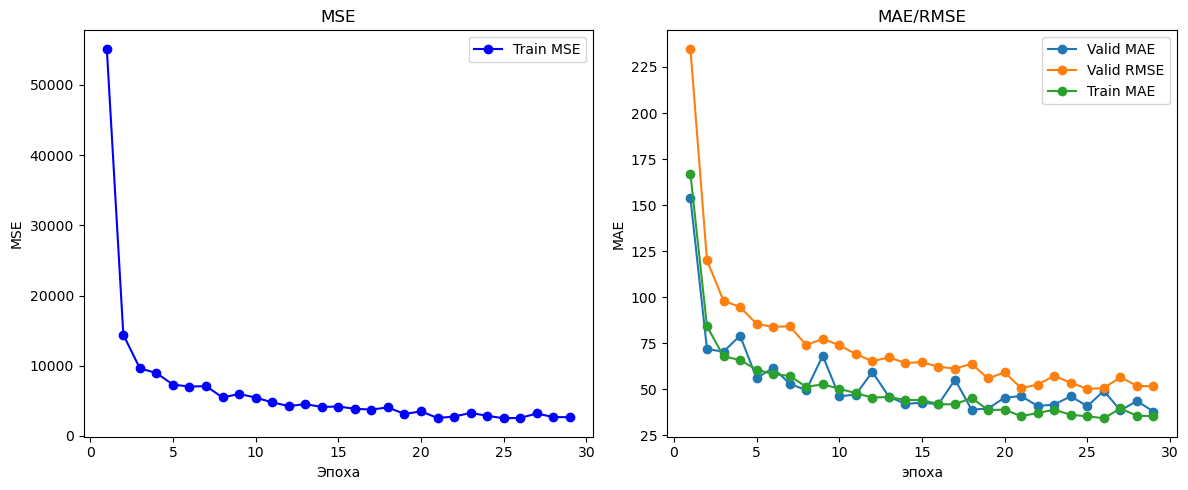

In [31]:
epochs = range(1, config.EPOCHS+1)
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, tmse2plot, marker='o', color='blue', label='Train MSE')
plt.title('MSE')
plt.xlabel('Эпоха')
plt.ylabel('MSE')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, vmae2plot, marker='o', label='Valid MAE')
plt.plot(epochs, np.sqrt(tmse2plot), marker='o',label='Valid RMSE')
plt.plot(epochs, tmae2plot, marker='o', label='Train MAE')
plt.title('MAE/RMSE')
plt.xlabel('эпоха')
plt.ylabel('MAE')
plt.legend()


plt.tight_layout()
plt.show() 

Так как при обучении критерием является MSE - по графику видно, что обучается хорошо

В итоге обучения модель показала значения MAE на тренировочной выборке 34.5, что лучше константной модели(не зря все делали), в тоже время MAE на валидации = 42.5


## Этап 3. Проверка качества модели на тестовых данных

Загрузим лучшую из полученных моделей и посмотри ее качество на валидационных данных

In [32]:
seed_everything(config.SEED)
model_deployed = MultimodalModel(config).to(device)
state_dict = torch.load("best_model.pth", weights_only=False)
model_deployed.load_state_dict(state_dict["model_state_dict"])

<All keys matched successfully>

In [33]:
tokenizer = AutoTokenizer.from_pretrained(config.TEXT_MODEL_NAME, clean_up_tokenization_spaces=True)
transforms = get_transforms(config, ds_type="val")


In [40]:
dataset2test = MultimodalDataset(config, transforms, ds_type="test")

In [41]:
loader = DataLoader(dataset2test,
                    batch_size=config.BATCH_SIZE,
                    shuffle=False,
                    collate_fn=partial(collate_fn,
                                        tokenizer=tokenizer))

In [42]:
mae2metric = MeanAbsoluteError().to(device)

mae_metric_test, predicted_vals= validate(model_deployed, loader, device, mae2metric, return_labels=True)

print(f"MAE: {mae_metric_test:.3f}")

MAE: 43.888


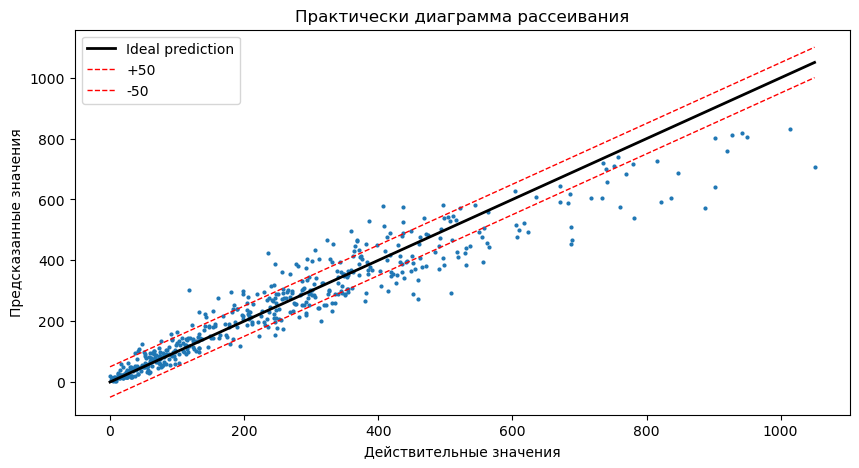

In [43]:
plt.figure(figsize=(10, 5))
plt.title('Практически диаграмма рассеивания')
plt.xlabel('Действительные значения')
plt.ylabel('Предсказанные значения')
plt.plot( test_data['total_calories'], predicted_vals, 'o', markersize=2)
# Линия идеального предсказания (y = x)
x_line = np.linspace(min(test_data['total_calories']), max(test_data['total_calories']), 100)
plt.plot(x_line, x_line, 'k-', linewidth=2, label='Ideal prediction')
#  ± 50 
plt.plot(x_line, x_line + 50, 'r--', linewidth=1, label='+50')
plt.plot(x_line, x_line - 50, 'r--', linewidth=1, label='-50')
plt.legend()
plt.show()

Параметр масса блюда хорошо "поджал" маленькие, низкокалорийные блюда

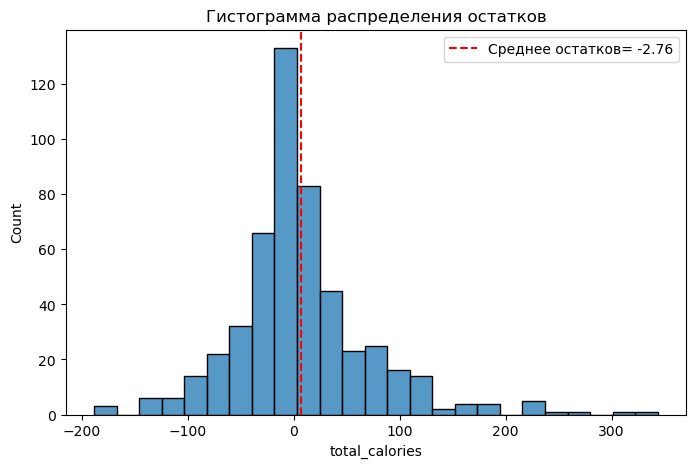

In [44]:
residuals =  test_data['total_calories'] - predicted_vals

plt.figure(figsize=(8,5))
sns.histplot(data=residuals, bins = 25)
plt.axvline(x = residuals.mean(), color = 'r', linestyle='dashed', label = 'Среднее остатков= ' +str(round(residuals.median(),2)))
plt.title ('Гистограмма распределения остатков')
plt.legend()
plt.show()

📊 1. Центр распределения

 - Пик гистограммы расположен вблизи нуля, что указывает на то, что модель в целом предсказывает калорийность корректно;

 - Среднее значение остатков: ≈ -2.76.

Это говорит о небольшом положительном смещении — модель слегка завышает предсказания.

📈 2. Форма распределения

 - Распределение похоже на нормальное (симметричное колоколоподобное);

 - Однако наблюдается небольшая асимметрия вправо — хвост распределения длиннее в положительную сторону;

 - Это означает, что модель иногда значительно переоценивает калорийность для высококалорийных блюд.

📏 3. Разброс значений

 - Большинство остатков находятся в диапазоне от –100 до +100;

 - Есть несколько выбросов до +300, и -150 где модель сильно ошибается.

Это может быть связано как с редкими блюдами как и с аномалиями в данных.

✅ 4. Итог

**Основная часть остатков мала и распределена около нуля — модель обучена адекватно**

Покажем 5 блюд для которых все очень плохо. Ошибка бывает же абсолютной и относительной можно посмотреть и то и другое

In [45]:
test4analdata=test_data.copy()
test4analdata['total_calories_predicted'] = predicted_vals
test4analdata['abs_error'] = abs((test4analdata['total_calories'] - test4analdata['total_calories_predicted']))
test4analdata['rel_error'] = abs((test4analdata['total_calories'] - test4analdata['total_calories_predicted']))/test4analdata['total_calories']*100
top5error4abs = test4analdata.sort_values("abs_error", ascending=False).head(5)
top5error4rel = test4analdata.sort_values("rel_error", ascending=False).head(5)

In [46]:
print('Блюда с максимальной абсолютно ошибкой:')
top5error4abs

Блюда с максимальной абсолютно ошибкой:


total_calories  total_mass  \
3095     1050.511108       277.0   
56        887.823059       407.0   
949       902.200012       416.0   
2004      781.958008       203.0   
1476      687.939026       119.0   

                                       ingredients2text          dish_id  \
3095                           almonds, sausage, grapes  dish_1558375886   
56                  apple, carrot, cauliflower, almonds  dish_1558720236   
949   carrot, goat cheese, olive oil, broccoli, spin...  dish_1565811139   
2004                 almonds, white rice, spinach (raw)  dish_1558549806   
1476                                            almonds  dish_1558375667   

      total_calories_predicted   abs_error  rel_error  
3095                707.064209  343.446899  32.693314  
56                  573.284729  314.538330  35.428042  
949                 640.716980  261.483032  28.982823  
2004                538.242065  243.715943  31.167395  
1476                455.066010  232.873016  33.850822

In [47]:
print('Блюда с максимальной относительной ошибкой:')
top5error4rel

Блюда с максимальной относительной ошибкой:


total_calories  total_mass ingredients2text          dish_id  \
263             0.00         1.0       plate only  dish_1557861216   
195             1.15         5.0    spinach (raw)  dish_1558461431   
26              2.30        10.0    spinach (raw)  dish_1558549773   
1833            2.53        11.0    spinach (raw)  dish_1558546434   
2410            2.53        11.0    spinach (raw)  dish_1559157777   

      total_calories_predicted  abs_error   rel_error  
263                  18.628481  18.628481         inf  
195                   7.153756   6.003756  522.065751  
26                   13.776958  11.476958  498.998153  
1833                 12.533695  10.003695  395.402973  
2410                 10.812593   8.282593  327.375236

Для блюд с относительной ошибкой - тенденция понятна - это маленькие блюда со шпинатом )

Большая абсолютная ошибка характерна для больших блюд - можно на них посмотреть

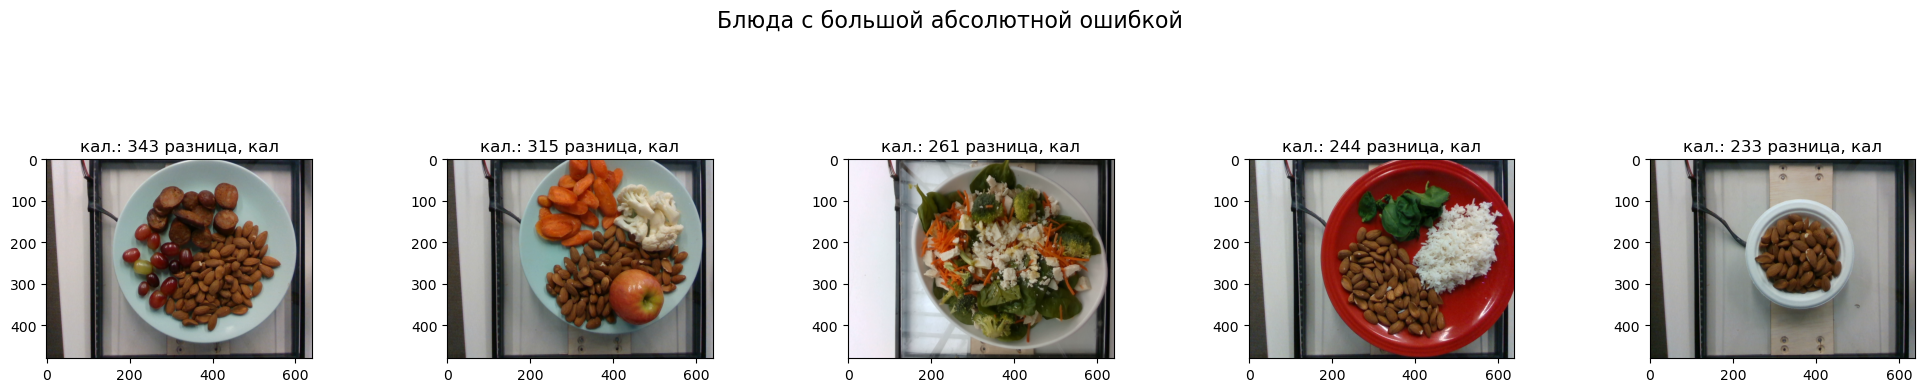

In [48]:
fig = plt.figure(figsize=(25,15))
fig.suptitle('Блюда с большой абсолютной ошибкой', fontsize=16)
plt.tight_layout()
for indx, food in enumerate(zip(top5error4abs['dish_id'],top5error4abs['abs_error'])):
    image = Image.open(image_path + food[0] + '/rgb.png')
    fig.add_subplot(5, 5, indx+1)
    plt.title(f"кал.: {round(food[1])} разница, кал")
    plt.imshow(image)
plt.show()

Модели не нравится миндаль. Наверное нужно больше соответствующих фотографий, ну и все таки есть противоречие, что по массе он не велик, но очень каллорийный. Кстати возможно и то, что модель очень внимательная к массе блюда и миндаль выбивается. Уменьшить значимость массы ?

Что стоит сделать для решения поставленной задачи:
- Наверное я бы ее переформулировал на оценку удельной калорийности - то есть считал бы кал/гр;
- Так как модель содержит описание ингредиентов, добавил бы фотографии каждого ингредиента в отдельности и много;
- Два запуска на ВМ мне кажется маловато для тестирования различных моделей, а на домашнем ноутбуке сложно решать такие задачи, но наверное стоило бы быть более аккуратным на стадии fused и пробовать объединять данные различными методами (не просто добавлять массу блюда как bias);
- Точно нужно больше данных для обучения - выборка на 3500 изображение все таки мала;
- Попробовать разные модели, не только "bert-base-uncased" и "tf_efficientnet_b0" - поискать на Hugging Face или похожие проекты на kaggle;
- Вообще недооценка калорийности больших блюд, что то с этим стоит сделать.